## Load libraries

In [6]:
import pandas as pd # load and manipulate data
import numpy as np # calculation
import matplotlib.pyplot as plt # visualize data
from sklearn.preprocessing import OneHotEncoder # To one-hot encode variables
import category_encoders as ce # To target encode high cardinality variables
from datetime import datetime
# to build the model
import xgboost as xgb
from xgboost import XGBRegressor

## Load raw dataset

In [7]:
demand = pd.read_csv('shopee_raw_data.csv')

In [8]:
### Ensure data privacy
import hashlib

def hash_value(value):
    return hashlib.sha256(value.encode()).hexdigest()

demand['product_name'] = demand['product_name'].apply(lambda x: hash_value(x))
demand['product_category'] = demand['product_category'].apply(lambda x: hash_value(x))
demand['brand'] = demand['brand'].apply(lambda x: hash_value(x))

print(demand)

             date   product_id  \
0        5/1/2024   3388329772   
1        5/2/2024   3388329772   
2        5/3/2024   3388329772   
3        5/4/2024   3388329772   
4        5/5/2024   3388329772   
...           ...          ...   
28671  11/26/2024  29205241595   
28672  11/27/2024  29205241595   
28673  11/28/2024  29205241595   
28674  11/29/2024  29205241595   
28675  11/30/2024  29205241595   

                                            product_name  \
0      c962b314933a9aa88002ec3c338e9a94bbd37353af8ca5...   
1      c962b314933a9aa88002ec3c338e9a94bbd37353af8ca5...   
2      c962b314933a9aa88002ec3c338e9a94bbd37353af8ca5...   
3      c962b314933a9aa88002ec3c338e9a94bbd37353af8ca5...   
4      c962b314933a9aa88002ec3c338e9a94bbd37353af8ca5...   
...                                                  ...   
28671  775ce3acc1e2742ef1b81ee8f23d3250b6932fbd2869de...   
28672  775ce3acc1e2742ef1b81ee8f23d3250b6932fbd2869de...   
28673  775ce3acc1e2742ef1b81ee8f23d3250b6932fbd2869

In [9]:
demand.to_csv('shopee_raw.csv')

## Overview

In [10]:
print(demand.head().to_string())

       date  product_id                                                      product_name                                                  product_category                                                             brand  traffic  impressions  payment  revenue  product_ad_spend  shop_ad_spend  auto_ad_spend  run_shop_ad  run_product_ad  product_page_bounce_count  traffic_from_search  wm_yr_wk  month  d  doubleday  near_dday  end_of_month  weekend  other_commercial_sale  day_offs  avg_price  promotion_on  promotion_price price_bin discount_rate  comment_received  product_rating  high_rating  high_discount  high_comment  avg_category_rate  avg_category_comment  week_of_month  wday  day_of_year  conversion_rate
0  5/1/2024  3388329772  c962b314933a9aa88002ec3c338e9a94bbd37353af8ca51da671406aa96ebf95  a44f96f2ae1f169df61a6ca60bda9010eeb3d754eaff98291d89a7d486a46905  0c11971ede300e8f8c3b1ce00d14d47474c4ef0206a9fd9532bbb462ab06916b        0            0        0        0                 0  

In [11]:
def check_unique_values(df):
    unique_values = {col: df[col].nunique() for col in df.columns}
    result_df = pd.DataFrame(list(unique_values.items()), columns=["Column Name", "Unique Value Count"])
    return result_df

check_unique_values(demand)

,Column Name,Unique Value Count
0,date,214
1,product_id,131
2,product_name,133
3,product_category,20
4,brand,13
5,traffic,56
6,impressions,97
7,payment,12
8,revenue,1185
9,product_ad_spend,567


In [12]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28676 entries, 0 to 28675
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       28676 non-null  object 
 1   product_id                 28676 non-null  int64  
 2   product_name               28676 non-null  object 
 3   product_category           28676 non-null  object 
 4   brand                      28676 non-null  object 
 5   traffic                    28676 non-null  int64  
 6   impressions                28676 non-null  int64  
 7   payment                    28676 non-null  int64  
 8   revenue                    28676 non-null  int64  
 9   product_ad_spend           28676 non-null  int64  
 10  shop_ad_spend              28676 non-null  int64  
 11  auto_ad_spend              28676 non-null  int64  
 12  run_shop_ad                28676 non-null  int64  
 13  run_product_ad             28676 non-null  int

Seems like we have some issues:
* Misalignment between `product_id` and `product_name`
* Some variables in the wrong data types

### Standardize data types

`date` should be in datetime data type

In [13]:
# Ensure the 'date' column is in datetime format
demand['date'] = pd.to_datetime(demand['date'])

# Sort the data by date, then product_id
demand = demand.sort_values(by=['product_id', 'date'])

`discount_rate` should be float   

`product_id` should be string

In [14]:
# Convert 'discount_rate' to float
demand['discount_rate'] = pd.to_numeric(
    demand['discount_rate'].str.replace('%', '', regex=False), 
    errors='coerce'
).astype(float).round(4)

# Convert 'product_id' to string
demand['product_id'] = demand['product_id'].astype(str)

Double-check

In [15]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28676 entries, 0 to 28675
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       28676 non-null  datetime64[ns]
 1   product_id                 28676 non-null  object        
 2   product_name               28676 non-null  object        
 3   product_category           28676 non-null  object        
 4   brand                      28676 non-null  object        
 5   traffic                    28676 non-null  int64         
 6   impressions                28676 non-null  int64         
 7   payment                    28676 non-null  int64         
 8   revenue                    28676 non-null  int64         
 9   product_ad_spend           28676 non-null  int64         
 10  shop_ad_spend              28676 non-null  int64         
 11  auto_ad_spend              28676 non-null  int64         
 12  run_

In [16]:
print(demand.head().to_string())

        date  product_id                                                      product_name                                                  product_category                                                             brand  traffic  impressions  payment  revenue  product_ad_spend  shop_ad_spend  auto_ad_spend  run_shop_ad  run_product_ad  product_page_bounce_count  traffic_from_search  wm_yr_wk  month  d  doubleday  near_dday  end_of_month  weekend  other_commercial_sale  day_offs  avg_price  promotion_on  promotion_price price_bin  discount_rate  comment_received  product_rating  high_rating  high_discount  high_comment  avg_category_rate  avg_category_comment  week_of_month  wday  day_of_year  conversion_rate
0 2024-05-01  3388329772  c962b314933a9aa88002ec3c338e9a94bbd37353af8ca51da671406aa96ebf95  a44f96f2ae1f169df61a6ca60bda9010eeb3d754eaff98291d89a7d486a46905  0c11971ede300e8f8c3b1ce00d14d47474c4ef0206a9fd9532bbb462ab06916b        0            0        0        0                 

### Fix misalignment between `product_id` and `product_name`

In [17]:
def check_row_misalignment(df, col1, col2):
    misaligned = df.groupby(col1)[col2].nunique().reset_index()
    misaligned = misaligned[misaligned[col2] > 1]
    return misaligned

misaligned_rows = check_row_misalignment(demand, 'product_id', 'product_name')
print(misaligned_rows)

misaligned_product_ids = misaligned_rows['product_id'].tolist()

print("Check these product_ids for misalignment between product_id and product_name:")
print(misaligned_product_ids)

     product_id  product_name
43  15765129329             2
76  21382736254             2
81  22150796991             2
Check these product_ids for misalignment between product_id and product_name:
['15765129329', '21382736254', '22150796991']


In [18]:
# # I check it manually with excel to investigate, if you want to see for yourself, you can uncomment these lines

# filtered_by_product_id = demand[demand['product_id'].isin(misaligned_product_ids)]

# # Check the shape of the DataFrame
# rows, columns = filtered_by_product_id.shape

# print(f"Number of rows: {rows}")
# print(f"Number of columns: {columns}")

# # Export data to check in excel
# filtered_by_product_id.to_csv('filtered_by_product_id.csv')

I examined the data and see that there are dates where `product_name` A in `product_id` 1 had data. Within that same date, `product_name` B corresponding to the same `product_id` has 0 for its variables. And vice versa. So I'll keep rows where the `product_id` has "meaningful data" (non-zero values for its important variables), and eliminate rows where the `product_id` carries 0 for its variables (impressions, traffic, etc.) in another `product_name` for the same `date`.

This is because in November, the sales admin changed the content of the product pages: keeping high performing `product_id` (meaning the `product_id` contains high rating, high comment volumes, etc), merging low performing products into that `product_id` and then changed the name of the corresponding `product_name`.

In [19]:
# Filter the DataFrame for misaligned product_ids
filtered_demand = demand[demand['product_id'].isin(misaligned_product_ids)]

# Case 1: Remove duplicate rows based on the specified subset of columns
filtered_demand = filtered_demand.drop_duplicates(subset=['date', 'product_id', 'traffic', 'impressions', 'payment'])

# Case 2: After Case 1, check for each combination of date & product_id, if there are 2 rows,
# keep the row with impressions > 0 or payment > 0, else remove the row with impressions = 0.
def filter_impressions_and_payment(group):
    if len(group) == 2:  # Ensure there are exactly 2 rows per combination
        # Check for rows where impressions = 0 and the other row has either impressions > 0 or payment > 0
        if (group['impressions'] == 0).any() and ((group['impressions'] > 0).any() or (group['payment'] > 0).any()):
            # Keep the row where impressions > 0 or payment > 0
            group = group[(group['impressions'] > 0) | (group['payment'] > 0)]
    return group

# Apply the filtering logic only to the filtered DataFrame
filtered_demand = filtered_demand.groupby(['date', 'product_id'], group_keys=False).apply(filter_impressions_and_payment)

/tmp/ipykernel_18517/3250136266.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_demand = filtered_demand.groupby(['date', 'product_id'], group_keys=False).apply(filter_impressions_and_payment)


In [20]:
# Group by 'product_id' and count the number of rows for each
date_counts = filtered_demand.groupby('product_id')['date'].count()

# Set display option to show all rows
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

# Print the total counts for each product_id
print("Total rows (all dates) for each product_id:")
print(date_counts)

Total rows (all dates) for each product_id:
product_id
15765129329    214
21382736254    214
22150796991    214
Name: date, dtype: int64


It's aligned now.

In [21]:
# Update the original DataFrame with the modified rows for misaligned product_ids
# First, drop the rows for the misaligned product_ids from the original DataFrame
demand = demand[~demand['product_id'].isin(misaligned_product_ids)]

# Then, append the filtered DataFrame back
demand = pd.concat([demand, filtered_demand], ignore_index=True)

## Feature engineering

### Ensure order of `date` for each `product_id`
Sorting will be applied first by `product_id` and then by `date`for creating lagging, and rolling features later

In [22]:
# Sort the data by product_id and date
demand = demand.sort_values(by=['product_id', 'date'])

demand.head()

,date,product_id,product_name,product_category,brand,traffic,impressions,payment,revenue,product_ad_spend,...,product_rating,high_rating,high_discount,high_comment,avg_category_rate,avg_category_comment,week_of_month,wday,day_of_year,conversion_rate
3424,2024-05-01,10070408774,d28887191c681dbf1caac11162e192ba5142d1606b815f...,f575e1ec32beef055e0bfcfe33625b06f92e89293878c8...,4f691cf8af4335990a792962f5f7edeed916234dbe17b3...,0,0,0,0,0,...,0.0,0,0,0,4.9,8,1,3,122,0.0
3425,2024-05-02,10070408774,d28887191c681dbf1caac11162e192ba5142d1606b815f...,f575e1ec32beef055e0bfcfe33625b06f92e89293878c8...,4f691cf8af4335990a792962f5f7edeed916234dbe17b3...,0,0,0,0,0,...,0.0,0,0,0,4.9,8,1,4,123,0.0
3426,2024-05-03,10070408774,d28887191c681dbf1caac11162e192ba5142d1606b815f...,f575e1ec32beef055e0bfcfe33625b06f92e89293878c8...,4f691cf8af4335990a792962f5f7edeed916234dbe17b3...,0,0,0,0,0,...,0.0,0,0,0,4.9,8,1,5,124,0.0
3427,2024-05-04,10070408774,d28887191c681dbf1caac11162e192ba5142d1606b815f...,f575e1ec32beef055e0bfcfe33625b06f92e89293878c8...,4f691cf8af4335990a792962f5f7edeed916234dbe17b3...,0,0,0,0,0,...,0.0,0,0,0,4.9,8,1,6,125,0.0
3428,2024-05-05,10070408774,d28887191c681dbf1caac11162e192ba5142d1606b815f...,f575e1ec32beef055e0bfcfe33625b06f92e89293878c8...,4f691cf8af4335990a792962f5f7edeed916234dbe17b3...,0,0,0,0,0,...,0.0,0,0,0,4.9,8,1,7,126,0.0


### sine/cosine transforms time variables to capture periodicity and cyclic patterns

In [23]:
# For cyclical encoding, use sine/cosine transforms
def cyclical_encode(series, max_val):
    # series are values from 1 to max_val
    # Convert to 0-based: (value-1)
    sine = np.sin(2 * np.pi * (series - 1) / max_val)
    cosine = np.cos(2 * np.pi * (series - 1) / max_val)
    return sine, cosine

# Cyclical encode weekday (7 days in a week)
demand['wday_sin'], demand['wday_cos'] = cyclical_encode(demand['wday'], 7)
# Cyclical encode month (12 months)
demand['month_sin'], demand['month_cos'] = cyclical_encode(demand['month'], 12)
# Cyclical encode week_of_the_month (assume up to 5 weeks in a month)
demand['wom_sin'], demand['wom_cos'] = cyclical_encode(demand['week_of_month'], 5)
# Cyclical encode day_of_year (assume up to 365 days in a year)
demand['day_of_year_sin'], demand['day_of_year_cos'] = cyclical_encode(demand['day_of_year'], 365)

### Lag and rolling features for important numeric columns
How I defined 'important' is based on domain knowledge and intuition first, then we can refine features later

In [24]:
# Define the columns to create the features on
numeric_cols = ['payment', 'revenue', 'product_ad_spend', 'shop_ad_spend', 'auto_ad_spend']

# Create lag features (e.g., lag_1, lag_3, lag_7, lag_14, lag_28)
lag_periods = [3, 28]
for col in numeric_cols:
    if col in demand.columns:
        for lag in lag_periods:
            demand[f'{col}_lag_{lag}'] = demand.groupby('product_id')[col].shift(lag) #Reset lagging for every product_id

### Create rolling features (example: 7-day rolling mean)

In [25]:
# Define the columns to create the features on
numeric_cols = ['traffic', 'impressions', 'payment', 'revenue', 'product_ad_spend', 'shop_ad_spend', 'auto_ad_spend']

rolling_windows = [7, 28]  # Define the rolling windows
for rolling_window in rolling_windows:
    for col in numeric_cols:  # Ensure these are the numeric columns you want to apply rolling features to
        if col in demand.columns:
            demand[f'{col}_rolling_{rolling_window}d_mean'] = (
                demand.groupby('product_id')[col] #Reset rolling for every product_id
                .transform(lambda x: x.shift(1).rolling(rolling_window).mean())
            )

### Category-level average within each month and each week
* There are homogenous patterns for each `product_category` (reference 'M5 Competition'), so we need to extract category-level data for the model to enhance learning process.
* Besides, in execution, it is easier to manage on category level, not on every single product level. So if we can learn anything helpful, we can apply into our category growth plan.

In [26]:
if 'product_category' in demand.columns:
    # Daily aggregation
    cat_rev = demand.groupby(['product_category', 'date'])['product_ad_spend'].mean().reset_index(name='cat_daily_avg_product_ad_spend')
    cat_traffic = demand.groupby(['product_category', 'date'])['traffic'].mean().reset_index(name='cat_daily_avg_traffic')

    # Monthly aggregation
    cat_month_rev = demand.groupby(['product_category', 'month'])['product_ad_spend'].mean().reset_index(name='cat_month_avg_product_ad_spend')
    cat_month_traffic = demand.groupby(['product_category', 'month'])['traffic'].mean().reset_index(name='cat_month_avg_traffic')

    # Weekly aggregation (assuming 'week_of_month' corresponds to the day of the week)
    cat_week_rev = demand.groupby(['product_category', 'week_of_month'])['product_ad_spend'].mean().reset_index(name='cat_week_avg_product_ad_spend')
    cat_week_traffic = demand.groupby(['product_category', 'week_of_month'])['traffic'].mean().reset_index(name='cat_week_avg_traffic')

    # Merging daily aggregated values back to the main dataframe
    demand = pd.merge(demand, cat_rev, on=['product_category', 'date'], how='left')
    demand = pd.merge(demand, cat_traffic, on=['product_category', 'date'], how='left')

    # Merging monthly aggregated values
    demand = pd.merge(demand, cat_month_rev, on=['product_category', 'month'], how='left')
    demand = pd.merge(demand, cat_month_traffic, on=['product_category', 'month'], how='left')

    # Merging weekly aggregated values
    demand = pd.merge(demand, cat_week_rev, on=['product_category', 'week_of_month'], how='left')
    demand = pd.merge(demand, cat_week_traffic, on=['product_category', 'week_of_month'], how='left')

#### Continuous zero-sale days until today
I learned about `continuous_zero_sales_days` from the repetitive feature engineering practices in the M5 competition. I believe this feature is highly effective in helping the model understand sporadic sales patterns for certain `product_id`s and `product_category`s.

In [27]:
# Sort data to ensure it is in time order
demand = demand.sort_values(by=['product_id', 'date'])

# Define continuous zero-sale days
def continuous_zero_sales(group):
    zero_sales_days = (group['payment'] == 0).astype(int)  # 1 if no sale, 0 otherwise
    return zero_sales_days.groupby((zero_sales_days != zero_sales_days.shift()).cumsum()).cumsum()

# Apply the function for each product_id
demand['continuous_zero_sales_days'] = (
    demand.groupby('product_id', group_keys=False).apply(continuous_zero_sales)
)

/tmp/ipykernel_18517/269506180.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  demand.groupby('product_id', group_keys=False).apply(continuous_zero_sales)


Since this feature is important, to create lagging and rolling features for it is not a bad idea, I reckon

In [28]:
# Rolling features for `continuous_zero_sales_days` on product_id level
# Rolling window of 14 days is based on domain knowledge and reviewing the dataset
rolling_window = 14
demand['zero_sales_rolling_mean_14d'] = (
    demand.groupby('product_id')['continuous_zero_sales_days']
          .transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
)
demand['zero_sales_rolling_max_14d'] = (
    demand.groupby('product_id')['continuous_zero_sales_days']
          .transform(lambda x: x.rolling(rolling_window, min_periods=1).max())
)

In [29]:
# Category level zero_sales_rolling_mean_14d
# Compute category-level average of zero_sales_rolling_mean_14d
cat_rolling_avg_zero_sales_14d = (
    demand.groupby(['product_category', 'date'])['zero_sales_rolling_mean_14d']
          .mean()
          .reset_index()
          .rename(columns={'zero_sales_rolling_mean_14d': 'cat_rolling_avg_zero_sales_14d'})
)

# Merge back to the original DataFrame
demand = pd.merge(demand, cat_rolling_avg_zero_sales_14d, on=['product_category', 'date'], how='left')

In [30]:
# Interaction between category-level rolling zero sales and promotion
demand['cat_zero_sales_x_promotion'] = (
    demand['cat_rolling_avg_zero_sales_14d'] * demand['promotion_on']
)

In [31]:
# Step 0: Ensure data is sorted by 'product_category' and 'date'
demand = demand.sort_values(by=['product_category', 'date'])

# Trend in rolling average of `continuous_zero_sales_days`
# Step 1: Compute category-level trend of zero_sales_rolling_mean_14d
# Ensure it considers time order properly
cat_trend = (
    demand.groupby(['product_category', 'date'])['cat_rolling_avg_zero_sales_14d']
          .mean()  # Aggregate for consistent value per 'product_category' and 'date'
          .groupby(level=0)  # Group again by 'product_category'
          .transform(lambda x: x.diff(14))  # Calculate 14-day trend
          .reset_index(name='cat_rolling_avg_zero_sales_trend_14d')  # Create a new DataFrame
)

# Step 2: Merge back to the original DataFrame on 'product_category' and 'date'
demand = pd.merge(demand, cat_trend, on=['product_category', 'date'], how='left')

# Percentage changes in rolling average of `continuous_zero_sales_days`
# Step 1: Compute category-level trend of zero_sales_rolling_mean_14d
# Ensure it considers time order properly
cat_pect_trend = (
    demand.groupby(['product_category', 'date'])['cat_rolling_avg_zero_sales_14d']
          .mean()  # Aggregate for consistent value per 'product_category' and 'date'
          .groupby(level=0)  # Group again by 'product_category'
          .transform(lambda x: x.pct_change(14))  # Calculate 14-day trend
          .reset_index(name='cat_rolling_avg_zero_sales_pct_change_14d')  # Create a new DataFrame
)

# Step 2: Merge back to the original DataFrame on 'product_category' and 'date'
demand = pd.merge(demand, cat_pect_trend, on=['product_category', 'date'], how='left')

In [32]:
# Sort data to ensure it is in time order
demand = demand.sort_values(by=['date', 'product_id'])

# Lagged values of category-level zero sales rolling average
for lag in [7, 14, 28]:
    demand[f'cat_rolling_avg_zero_sales_lag_{lag}d'] = (
        demand.groupby('product_id')['cat_rolling_avg_zero_sales_14d']
              .transform(lambda x: x.shift(lag))
    )

## Normalized price-related variables:
* Scale: category level

In [33]:
# Step 1: Group by 'product_category' and calculate mean and std for 'avg_price' and 'promotion_price'
category_stats = demand.groupby('product_category').agg(
    avg_price_mean=('avg_price', 'mean'),
    avg_price_std=('avg_price', 'std'),
    promotion_price_mean=('promotion_price', 'mean'),
    promotion_price_std=('promotion_price', 'std')
).reset_index()

# Step 2: Merge these statistics back to the original DataFrame
demand = pd.merge(demand, category_stats, on='product_category', how='left')

# Step 3: Create normalized columns
demand['normalized_avg_price'] = (demand['avg_price'] - demand['avg_price_mean']) / demand['avg_price_std']
demand['normalized_promotion_price'] = (demand['promotion_price'] - demand['promotion_price_mean']) / demand['promotion_price_std']

# Dropping unnecessary intermediate columns for cleanliness (optional)
demand = demand.drop(columns=['avg_price_mean', 'avg_price_std', 'promotion_price_mean', 'promotion_price_std'])

### Features based on domain knowledge

In [34]:
# Ad spend during promotion, weekend
if 'promotion_on' in demand.columns and 'product_ad_spend' in demand.columns:
    demand['ad_spend_during_promotion'] = demand['product_ad_spend'] * demand['promotion_on']

if 'weekend' in demand.columns and 'product_ad_spend' in demand.columns:
    demand['weekend_ad_spend'] = demand['weekend'] * demand['product_ad_spend']

In [35]:
# CTR
if 'traffic' in demand.columns and 'impressions' in demand.columns:
    demand['CTR'] = np.where(demand['impressions'] == 0, 0, demand['traffic'] / demand['impressions'])

### Last steps
## One-hot encoding

In [36]:
# Identify categorical features for one-hot encoding
cat_cols = []
for col in ['product_category', 'brand', 'price_bin']:
    if col in demand.columns and demand[col].dtype == 'object':
        cat_cols.append(col)

# Perform one-hot encoding
if cat_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Use sparse_output instead of sparse
    # Fit-transform
    ohe_data = ohe.fit_transform(demand[cat_cols])
    # Create a DataFrame with OHE results
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(cat_cols), index=demand.index)
    # Concatenate back
    demand = pd.concat([demand.drop(cat_cols, axis=1), ohe_df], axis=1)

Due to the high cardinality of `product_id`, one-hot encoding is not a suitable approach.

So I'll try target encoding on it.

## Target encoding: product_id

In [37]:
#Instantiate a target encoder
te = ce.TargetEncoder(cols=['product_id'])

# Fit the encoder on the training set
demand['product_id_target_enc'] = te.fit_transform(demand['product_id'], demand['payment'])

# Drop original if desired
demand.drop('product_id', axis=1, inplace=True)

In [38]:
## Drop columns to avoid duplication in learning
demand = demand.drop(['wday', 'month', 'week_of_month', 'product_name', 'day_of_year'], axis=1)

## Modeling

### Define features and target

In [39]:
# Review all variables
demand.columns.tolist()

['date',
 'traffic',
 'impressions',
 'payment',
 'revenue',
 'product_ad_spend',
 'shop_ad_spend',
 'auto_ad_spend',
 'run_shop_ad',
 'run_product_ad',
 'product_page_bounce_count',
 'traffic_from_search',
 'wm_yr_wk',
 'd',
 'doubleday',
 'near_dday',
 'end_of_month',
 'weekend',
 'other_commercial_sale',
 'day_offs',
 'avg_price',
 'promotion_on',
 'promotion_price',
 'discount_rate',
 'comment_received',
 'product_rating',
 'high_rating',
 'high_discount',
 'high_comment',
 'avg_category_rate',
 'avg_category_comment',
 'conversion_rate',
 'wday_sin',
 'wday_cos',
 'month_sin',
 'month_cos',
 'wom_sin',
 'wom_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'payment_lag_3',
 'payment_lag_28',
 'revenue_lag_3',
 'revenue_lag_28',
 'product_ad_spend_lag_3',
 'product_ad_spend_lag_28',
 'shop_ad_spend_lag_3',
 'shop_ad_spend_lag_28',
 'auto_ad_spend_lag_3',
 'auto_ad_spend_lag_28',
 'traffic_rolling_7d_mean',
 'impressions_rolling_7d_mean',
 'payment_rolling_7d_mean',
 'revenue_rolling_

#### Exclude some variables out of features used for training:
* Prevent data leakage: Ensure that information unavailable at prediction time is not included in the training process.
* Avoid duplication: Eliminate redundant features that may skew the model's learning.
* Align with learning objectives: Select features based on the specific goals of the model.

In [40]:
exclude_cols = ['conversion_rate', 'payment', 'revenue_rolling_28d_mean', 'revenue_rolling_7d_mean', 'revenue_lag_28', 'revenue_lag_3', 'd', 'wm_yr_wk', 'revenue']  # Adjust as needed
features = [col for col in demand.columns if col not in exclude_cols]
target = 'payment'

## Cross-validation training

In [41]:
# Helper function for creating CV folds while reserving time order
def split_by_month(df, train_end_month, val_month, features, target):
    train_end = pd.to_datetime(train_end_month + '-01') + pd.offsets.MonthEnd(1)
    val_start = pd.to_datetime(val_month + '-01')
    val_end = val_start + pd.offsets.MonthEnd(1)

    train_df = df[df['date'] <= train_end]
    val_df = df[(df['date'] >= val_start) & (df['date'] <= val_end)]

    X_train = train_df[features]
    y_train = train_df[target]
    X_val = val_df[features]
    y_val = val_df[target]

    return X_train, y_train, X_val, y_val

# ---- TIME-BASED CROSS-VALIDATION ----

train_end_month_list = ['2024-07', '2024-08', '2024-09']
val_month_list       = ['2024-08', '2024-09', '2024-10']

cv_rmse_scores = []

for train_end, val_month in zip(train_end_month_list, val_month_list):
    X_train, y_train, X_val, y_val = split_by_month(demand, train_end, val_month, features, target)

    # Convert to numeric/categorical/bool only, if needed
    X_train = X_train.select_dtypes(include=[np.number, 'category', 'bool'])
    X_val = X_val.select_dtypes(include=[np.number, 'category', 'bool'])

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.1,
        'max_depth': 6
    }

    # Training
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dval, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    val_preds = model.predict(dval)
    val_rmse = np.sqrt(np.mean((y_val - val_preds)**2))
    cv_rmse_scores.append(val_rmse)

    print(f"Train End: {train_end}, Validation Month: {val_month}, RMSE: {val_rmse:.3f}")

avg_rmse = np.mean(cv_rmse_scores)
print(f"\nTime-based CV Average RMSE: {avg_rmse:.3f}")

Train End: 2024-07, Validation Month: 2024-08, RMSE: 0.299
Train End: 2024-08, Validation Month: 2024-09, RMSE: 0.226
Train End: 2024-09, Validation Month: 2024-10, RMSE: 0.277

Time-based CV Average RMSE: 0.267


## Run model on test data: November data

In [42]:
# Test set

X_train, y_train, X_val, y_val = split_by_month(demand, '2024-10', '2024-11', features, target)
X_train = X_train.select_dtypes(include=[np.number, 'category', 'bool'])
X_val = X_val.select_dtypes(include=[np.number, 'category', 'bool'])

# dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val) # Test set

# Run prediction
final_preds = model.predict(dval)

## Evaluate November performance
nov_rmse = np.sqrt(np.mean((y_val - final_preds)**2))
print(f"November RMSE: {nov_rmse:.3f}")

November RMSE: 0.240


## Plot Prediction vs. Actual

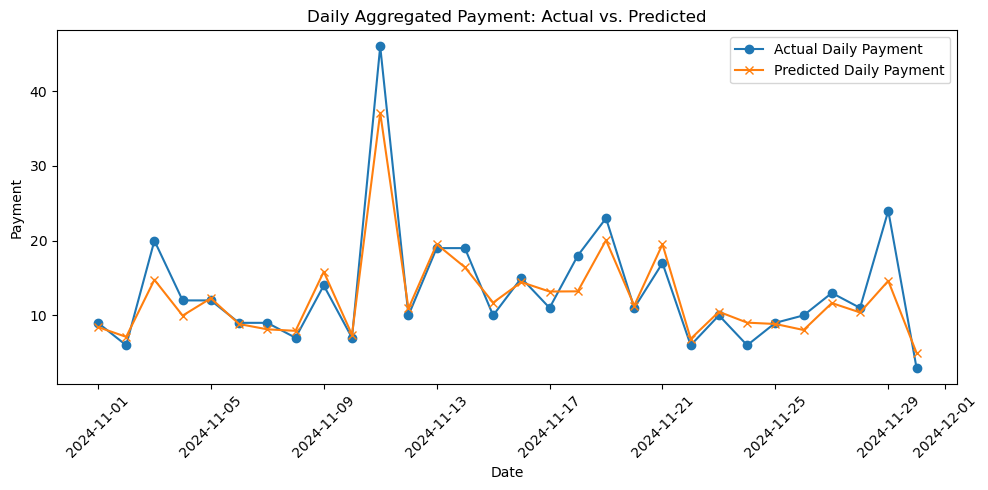

In [43]:
val_df = demand[(demand['date'] >= '2024-11-01') & (demand['date'] <= '2024-11-30')].copy()

# Ensure val_df is sorted by date for a proper line plot
val_df.sort_values(by='date', inplace=True)

val_df['predicted_payment'] = final_preds

# 1) Aggregate payments by date
daily_agg = (
    val_df
    .groupby('date', as_index=False)
    .agg({'payment': 'sum', 'predicted_payment': 'sum'})
    .rename(columns={
        'payment': 'actual_daily_payment',
        'predicted_payment': 'predicted_daily_payment'
    })
)

# 2) Ensure chronological order
daily_agg.sort_values('date', inplace=True)

# 3) Plot both series on the same line chart
plt.figure(figsize=(10, 5))
plt.plot(daily_agg['date'], daily_agg['actual_daily_payment'], marker='o', label='Actual Daily Payment')
plt.plot(daily_agg['date'], daily_agg['predicted_daily_payment'], marker='x', label='Predicted Daily Payment')
plt.xlabel('Date')
plt.ylabel('Payment')
plt.title('Daily Aggregated Payment: Actual vs. Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Importance

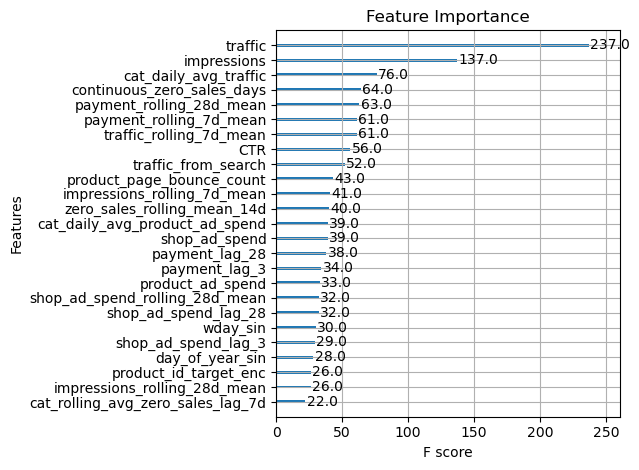

In [44]:
xgb.plot_importance(model, max_num_features=25)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

### Save the model to a file

In [45]:
model.save_model('ecom_pred_xgboost_model.json')

# Later, you can load it back like this:
# loaded_model = xgb.Booster()
# loaded_model.load_model('xgboost_model.json')

## Hyperparameter fine-tuning
TBU